In [3]:
# libraries required

import numpy as np
import pandas as pd
import torch
from sklearn.metrics.pairwise import polynomial_kernel, linear_kernel, sigmoid_kernel, rbf_kernel, laplacian_kernel
import torch.nn as nn
from torch import optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !git clone "https://github.com/Carlosespicur/tfm_esteban"

Cloning into 'tfm_esteban'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 29.44 MiB | 26.49 MiB/s, done.


In [4]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return torch.Tensor(polynomial_kernel(X = X, degree = degree, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "sigmoid":

        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return torch.Tensor(sigmoid_kernel(X = X, gamma = gamma, coef0 = coef))
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return torch.Tensor(rbf_kernel(X = X, gamma = gamma))
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return torch.Tensor(laplacian_kernel(X = X, gamma = gamma))
        else:
            return None

    else:
        return None


In [5]:
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):

        super().__init__()

        activation = nn.ReLU() # activation function
        self.z = None # embedded vector

        self.encoder_layers = nn.ModuleList()
        self.decoder_layers = nn.ModuleList()

        # Encoder
        enc_layer_sizes = [input_size, 256, 128, latent_size]
        for k in range(len(enc_layer_sizes)-1):
          layer = nn.Linear(enc_layer_sizes[k], enc_layer_sizes[k+1])
          # weights initialization
          nn.init.xavier_uniform(layer.weight)
          layer.bias.data.fill_(0.01)

          self.encoder_layers.append(layer)
          self.encoder_layers.append(activation)

        # Decoder
        dec_layer_sizes = [latent_size, 64, input_size]
        for k in range(len(dec_layer_sizes)-1):
          layer = nn.Linear(dec_layer_sizes[k], dec_layer_sizes[k+1])
          # weights initialization
          nn.init.xavier_uniform(layer.weight)
          layer.bias.data.fill_(0.01)

          self.decoder_layers.append(layer)
          self.decoder_layers.append(activation)


    def forward(self, x):
        for layer in self.encoder_layers:
          x = layer(x)

        self.z = x

        for layer in self.decoder_layers:
          x = layer(x)

        return x

In [6]:
class autoencoder_SLMVP():

    """ Training an autoencoder architecture with custom loss function inspired by SLMVP """

    def __init__(self, autoencoder, optimizer, kernel_parameters_X, kernel_parameters_Y = None ,lam = 1., label_indep = False, c = 1, mu = 1):

        self.lam = lam # regularization parameter
        self.c = c # constant used in cost function for the training process
        self.mu = mu # regularization parameter for leveling supervised trace error and search space requirements
        self.autoencoder = autoencoder
        self.out = None
        self.z = None # embeddings
        self.optimizer = optimizer
        self.recon_loss = nn.MSELoss() # reconstruction loss
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep

    def train(self, train_loader):

        self.autoencoder.train() # training mode: model parameters can be updated

        epoch_recon_losses = [] # log of each minibatch reconstruction loss
        epoch_sup_losses = [] # log of each minibatch supervised loss
        epoch_restriction_losses = [] # log of each minibatch search space restriction loss
        epoch_losses = [] # log of each minibatch total loss

        for X, Y in tqdm(train_loader):

            self.optimizer.zero_grad() # clear gradients
            preds = self.autoencoder(X)

            # Compute similarity matrices
            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
               K_Y = binary_distance(Y.unsqueeze(1), Y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(Y, **self.kernel_parameters_Y)
            #######################

            # l = K_X.shape[0]
            # j = np.ones(l)

            # K_X = K_X - (np.dot(np.dot(j,j.T),K_X))/l - (np.dot(K_X,np.dot(j,j.T)))/l + (np.dot((np.dot(j.T,np.dot(K_X,j))),np.dot(j,j.T)))/(np.power(l,2))

            # print(K_X, K_Y)
            # input()

            #######################
            K_XY = K_X * K_Y
            D = torch.diag(torch.sum(K_XY, dim = 1))

            recon_loss = self.recon_loss(preds, X) # reconstruction error

            # # OPCIÓN PÉRDIDA 1: maximizar la traza
            # sup_loss= -torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), K_XY), self.autoencoder.z)) # supervised trace error
            # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # We only want to consider matrices that satisfy sup_loss_restriction = 0
            # loss = (1-self.lam) * recon_loss + self.lam * (self.mu * sup_loss + (1-self.mu) * sup_loss_restriction)

            # # OPCIÓN PÉRDIDA 2: minimizar la traza --> Problema: los pesos tienden a hacerse cero
            # L = D - K_XY
            # sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
            # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # IGNORAR!!!!!!! No se utiliza para calcular la pérdida
            # loss = (1-self.lam) * recon_loss + self.lam * sup_loss

            # OPCIÓN PÉRDIDA 3: minimizar la traza manteniendo pesos grandes. Maximizamos tr(Z^T * Z) en paralelo para ello
            L = D - K_XY
            sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
            sup_loss_restriction = (torch.trace(torch.matmul(torch.t(self.autoencoder.z), self.autoencoder.z)) - self.c)**2
            loss = (1-self.lam) * recon_loss + self.lam * sup_loss + self.mu * sup_loss_restriction


            epoch_recon_losses.append(recon_loss)
            epoch_sup_losses.append(sup_loss)
            epoch_restriction_losses.append(sup_loss_restriction)
            epoch_losses.append(loss)


            loss.backward() # Compute gradients
            self.optimizer.step() # Update model parameters

        avg_recon_loss = torch.mean(torch.tensor(epoch_recon_losses))
        avg_sup_loss = torch.mean(torch.tensor(epoch_sup_losses))
        avg_restriction_loss = torch.mean(torch.tensor(epoch_restriction_losses))
        avg_loss = torch.mean(torch.tensor(epoch_losses))

        return avg_recon_loss.item(), avg_sup_loss.item(), avg_restriction_loss.item() ,avg_loss.item()

    def test(self, data_loader):

      self.autoencoder.eval() # Evaluation mode: model parameters cannot be modified

      test_recon_losses = [] # log of minibatch-reconstruction losses
      test_sup_losses = [] # log of minibatch supervised losses
      test_restriction_losses = [] # log of each minibatch search space restriction loss
      test_losses = [] # log of minibatch losses

      for X, Y in data_loader:

        preds = self.autoencoder(X)

        # Compute similarity matrices
        K_X = kernel(X, **self.kernel_parameters_X)
        if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
            K_Y = binary_distance(Y.unsqueeze(1), Y.unsqueeze(1))

        else:
            if self.kernel_parameters_Y == None:
                self.kernel_parameters_Y = self.kernel_parameters_X
            K_Y = kernel(Y, **self.kernel_parameters_Y)

        K_XY = K_X * K_Y
        D = torch.diag(torch.sum(K_XY, dim = 1))

        recon_loss = self.recon_loss(preds, X) # reconstruction error

        # # OPCIÓN PÉRDIDA 1: maximizar la traza
        # sup_loss= -torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), K_XY), self.autoencoder.z)) # supervised trace error
        # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # We only want to consider matrices that satisfy sup_loss_restriction = 0
        # loss = (1-self.lam) * recon_loss + self.lam * (self.mu * sup_loss + (1-self.mu) * sup_loss_restriction)

        # # OPCIÓN PÉRDIDA 2: minimizar la traza --> Problema: los pesos tienden a hacerse cero
        # L = D - K_XY
        # sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
        # sup_loss_restriction = (torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), D), self.autoencoder.z)) - self.c)**2 # IGNORAR!!!!!!!!!!!! No se utiliza para calcular la pérdida
        # loss = (1-self.lam) * recon_loss + self.lam * sup_loss

        # OPCIÓN PÉRDIDA 3: minimizar la traza manteniendo pesos grandes. Maximizamos tr(Z^T * Z) en paralelo para ello
        L = D - K_XY
        sup_loss = torch.trace(torch.matmul(torch.matmul(torch.t(self.autoencoder.z), L), self.autoencoder.z))
        sup_loss_restriction = (torch.trace(torch.matmul(torch.t(self.autoencoder.z), self.autoencoder.z)) - self.c)**2
        loss = (1-self.lam) * recon_loss + self.lam * sup_loss + self.mu * sup_loss_restriction

        test_recon_losses.append(recon_loss)
        test_sup_losses.append(sup_loss)
        test_restriction_losses.append(sup_loss_restriction)
        test_losses.append(loss)

      avg_recon_loss = torch.mean(torch.tensor(test_recon_losses))
      avg_sup_loss = torch.mean(torch.tensor(test_sup_losses))
      avg_restriction_loss = torch.mean(torch.tensor(test_restriction_losses))
      avg_loss = torch.mean(torch.tensor(test_losses))

      return avg_recon_loss.item(), avg_sup_loss.item(), avg_restriction_loss.item(), avg_loss.item()


Model hyperparameters

In [ ]:
# Model hyperparameters

lr = 0.001 # learning rate
batch_size = 64
epochs = 40
lam = 0.01 # regularisation parameter for levelling reconstruction error and supervised trace error
mu = 10 # regularisation parameter for levelling supervised trace error and search space requirements
# c = None # constant that determines the ideal search space for encoder parameters. Defined in the next cell as dimensionality of the data
latent_size = 64 # latent space dimension

# kernel function parameters for X_train / X_test

kernel_param_X = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1e-2,
    "coef": 0.5e2

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

Preparing Fashion MNIST Dataset


In [ ]:
# Standard scaling

# train_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_train.csv")
# test_data = pd.read_csv("../datasets/fashion_MNIST/fashion-mnist_test.csv")
# data = pd.concat([train_data, test_data], ignore_index = True)
# # print(train_data.shape, test_data.shape, data.shape)
# # data.head()
# train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# # print(train_data["label"].value_counts(normalize=True))
# # print(val_data["label"].value_counts(normalize=True))
# # print(test_data["label"].value_counts(normalize=True))

# sc = StandardScaler()
# X_train = train_data.drop("label", axis = 1, inplace=False)
# X_train = sc.fit_transform(X_train)
# X_train = torch.tensor(X_train, dtype = torch.float)
# y_train = train_data["label"].values
# y_train = torch.tensor(y_train, dtype = torch.float)
# X_val = val_data.drop("label", axis = 1, inplace=False)
# X_val = sc.fit_transform(X_val)
# X_val = torch.tensor(X_val, dtype = torch.float)
# y_val = val_data["label"].values
# y_val = torch.tensor(y_val, dtype = torch.float)
# X_test = test_data.drop("label", axis = 1, inplace=False)
# X_test = sc.fit_transform(X_test)
# X_test = torch.tensor(X_test, dtype = torch.float)
# y_test = test_data["label"].values
# y_test = torch.tensor(y_test, dtype = torch.float)
# c = X_train.shape[1]
# train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
# val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
# test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)


In [ ]:
# normalization dividing by 255

train_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_train.csv")
test_data = pd.read_csv("/content/tfm_esteban/fashion_MNIST/fashion-mnist_test.csv")
data = pd.concat([train_data, test_data], ignore_index = True)
# print(train_data.shape, test_data.shape, data.shape)
# data.head()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data["label"], random_state=20)
train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True, stratify=train_data["label"], random_state=20)

# print(train_data["label"].value_counts(normalize=True))
# print(val_data["label"].value_counts(normalize=True))
# print(test_data["label"].value_counts(normalize=True))

X_train = np.array(train_data.drop("label", axis = 1, inplace=False))/255
X_train = torch.tensor(X_train, dtype = torch.float)
y_train = train_data["label"].values
y_train = torch.tensor(y_train, dtype = torch.float)
X_val = np.array(val_data.drop("label", axis = 1, inplace=False))/255
X_val = torch.tensor(X_val, dtype = torch.float)
y_val = val_data["label"].values
y_val = torch.tensor(y_val, dtype = torch.float)
X_test = np.array(test_data.drop("label", axis = 1, inplace=False))/255
X_test = torch.tensor(X_test, dtype = torch.float)
y_test = test_data["label"].values
y_test = torch.tensor(y_test, dtype = torch.float)
c = X_train.shape[1]
train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)


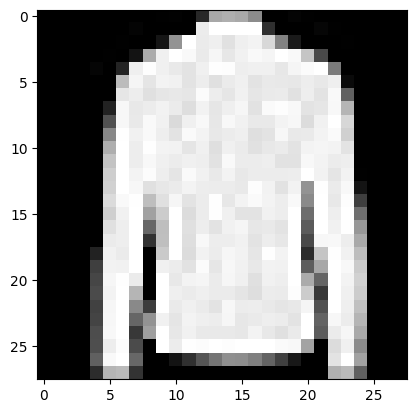

In [ ]:
plt.imshow(X_train[7].reshape(28,28), cmap="gray")

Model training and testing

In [ ]:
# Model creation
input_size = X_train.shape[1]
base = autoencoder(input_size, latent_size)
optimizer = torch.optim.Adam(base.parameters(), lr=lr, weight_decay=1e-5)
model = autoencoder_SLMVP(base, optimizer, kernel_param_X, kernel_param_Y, lam, label_indep, c, mu)

<ipython-input-4-99a238167c10>:17: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
<ipython-input-4-99a238167c10>:28: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [ ]:
# Model training

for epoch in range(epochs):

    print(f"*********** Epoch: {epoch + 1}/{epochs} *******************")
    train_avg_recon_loss, train_avg_sup_loss, train_avg_sup_restriction_loss,train_avg_loss = model.train(train_loader)
    print(f"recon_loss: {train_avg_recon_loss}, avg_sup_loss: {train_avg_sup_loss}, avg_sup_restrinction_loss: {train_avg_sup_restriction_loss} ,total_loss: {train_avg_loss}")
    val_avg_recon_loss, val_avg_sup_loss, val_avg_sup_restriction_loss, val_avg_loss = model.test(val_loader)
    print(f"val_data --> recon_loss: {val_avg_recon_loss}, avg_sup_loss: {val_avg_sup_loss}, avg_sup_restrinction_loss: {val_avg_sup_restriction_loss} ,total_loss: {val_avg_loss}")

*********** Epoch: 1/40 *******************


100%|██████████| 788/788 [00:09<00:00, 82.22it/s]


recon_loss: 0.07999830693006516, avg_sup_loss: 12834930.0, avg_sup_restrinction_loss: 5086.31005859375 ,total_loss: 179212.46875
val_data --> recon_loss: 0.07995063811540604, avg_sup_loss: 2998634.75, avg_sup_restrinction_loss: 29373.5703125 ,total_loss: 323722.125
*********** Epoch: 2/40 *******************


100%|██████████| 788/788 [00:11<00:00, 70.16it/s]


recon_loss: 0.08368582278490067, avg_sup_loss: 711748.125, avg_sup_restrinction_loss: 415.5021057128906 ,total_loss: 11272.5859375
val_data --> recon_loss: 0.0868813693523407, avg_sup_loss: 144131.46875, avg_sup_restrinction_loss: 4273.142578125 ,total_loss: 44172.82421875
*********** Epoch: 3/40 *******************


100%|██████████| 788/788 [00:15<00:00, 50.74it/s]


recon_loss: 0.08713062107563019, avg_sup_loss: 49245.09765625, avg_sup_restrinction_loss: 249.5067596435547 ,total_loss: 2987.604736328125
val_data --> recon_loss: 0.08710562437772751, avg_sup_loss: 26066.564453125, avg_sup_restrinction_loss: 3429.645263671875 ,total_loss: 34557.203125
*********** Epoch: 4/40 *******************


100%|██████████| 788/788 [00:19<00:00, 40.51it/s]


recon_loss: 0.08719373494386673, avg_sup_loss: 20143.453125, avg_sup_restrinction_loss: 246.37144470214844 ,total_loss: 2665.23583984375
val_data --> recon_loss: 0.0874733030796051, avg_sup_loss: 12809.23046875, avg_sup_restrinction_loss: 3276.953125 ,total_loss: 32897.71484375
*********** Epoch: 5/40 *******************


100%|██████████| 788/788 [00:20<00:00, 37.59it/s]


recon_loss: 0.08715888112783432, avg_sup_loss: 9392.4677734375, avg_sup_restrinction_loss: 234.29364013671875 ,total_loss: 2436.947265625
val_data --> recon_loss: 0.08750832080841064, avg_sup_loss: 6539.35888671875, avg_sup_restrinction_loss: 3030.181396484375 ,total_loss: 30367.294921875
*********** Epoch: 6/40 *******************


100%|██████████| 788/788 [00:20<00:00, 39.28it/s]


recon_loss: 0.08713103830814362, avg_sup_loss: 4616.53515625, avg_sup_restrinction_loss: 242.59811401367188 ,total_loss: 2472.23291015625
val_data --> recon_loss: 0.0874544084072113, avg_sup_loss: 3591.508544921875, avg_sup_restrinction_loss: 3271.214111328125 ,total_loss: 32748.142578125
*********** Epoch: 7/40 *******************


100%|██████████| 788/788 [00:20<00:00, 39.32it/s]


recon_loss: 0.0870983898639679, avg_sup_loss: 2569.831298828125, avg_sup_restrinction_loss: 247.1533203125 ,total_loss: 2497.31787109375
val_data --> recon_loss: 0.0874667689204216, avg_sup_loss: 2306.931884765625, avg_sup_restrinction_loss: 3422.7578125 ,total_loss: 34250.734375
*********** Epoch: 8/40 *******************


100%|██████████| 788/788 [00:22<00:00, 35.51it/s]


recon_loss: 0.08710726350545883, avg_sup_loss: 1639.90087890625, avg_sup_restrinction_loss: 249.35121154785156 ,total_loss: 2509.997314453125
val_data --> recon_loss: 0.08750070631504059, avg_sup_loss: 1409.6805419921875, avg_sup_restrinction_loss: 3552.347900390625 ,total_loss: 35537.6640625
*********** Epoch: 9/40 *******************


100%|██████████| 788/788 [00:24<00:00, 31.66it/s]


recon_loss: 0.08712881058454514, avg_sup_loss: 1070.5643310546875, avg_sup_restrinction_loss: 251.65570068359375 ,total_loss: 2527.34912109375
val_data --> recon_loss: 0.08748883754014969, avg_sup_loss: 921.2700805664062, avg_sup_restrinction_loss: 3602.2392578125 ,total_loss: 36031.6953125
*********** Epoch: 10/40 *******************


100%|██████████| 788/788 [00:25<00:00, 31.01it/s]


recon_loss: 0.08709689974784851, avg_sup_loss: 660.2095947265625, avg_sup_restrinction_loss: 252.5168914794922 ,total_loss: 2531.857177734375
val_data --> recon_loss: 0.08774959295988083, avg_sup_loss: 709.1939697265625, avg_sup_restrinction_loss: 3676.6103515625 ,total_loss: 36773.28515625
*********** Epoch: 11/40 *******************


100%|██████████| 788/788 [00:26<00:00, 29.30it/s]


recon_loss: 0.08707508444786072, avg_sup_loss: 450.04351806640625, avg_sup_restrinction_loss: 253.35069274902344 ,total_loss: 2538.093505859375
val_data --> recon_loss: 0.08759727329015732, avg_sup_loss: 471.9976806640625, avg_sup_restrinction_loss: 3690.572509765625 ,total_loss: 36910.52734375
*********** Epoch: 12/40 *******************


100%|██████████| 788/788 [00:30<00:00, 26.15it/s]


recon_loss: 0.0870741531252861, avg_sup_loss: 606.8921508789062, avg_sup_restrinction_loss: 251.54385375976562 ,total_loss: 2521.593505859375
val_data --> recon_loss: 0.08754036575555801, avg_sup_loss: 313.0945739746094, avg_sup_restrinction_loss: 3667.0517578125 ,total_loss: 36673.73828125
*********** Epoch: 13/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.69it/s]


recon_loss: 0.08706741780042648, avg_sup_loss: 194.09547424316406, avg_sup_restrinction_loss: 252.78805541992188 ,total_loss: 2529.907470703125
val_data --> recon_loss: 0.08736494183540344, avg_sup_loss: 211.6118621826172, avg_sup_restrinction_loss: 3666.652099609375 ,total_loss: 36668.72265625
*********** Epoch: 14/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.56it/s]


recon_loss: 0.08704813569784164, avg_sup_loss: 145.02955627441406, avg_sup_restrinction_loss: 253.0239715576172 ,total_loss: 2531.776123046875
val_data --> recon_loss: 0.08743735402822495, avg_sup_loss: 172.2954864501953, avg_sup_restrinction_loss: 3613.116455078125 ,total_loss: 36132.97265625
*********** Epoch: 15/40 *******************


100%|██████████| 788/788 [00:33<00:00, 23.88it/s]


recon_loss: 0.08704567700624466, avg_sup_loss: 75.89543914794922, avg_sup_restrinction_loss: 251.93470764160156 ,total_loss: 2520.192138671875
val_data --> recon_loss: 0.08741118758916855, avg_sup_loss: 155.62176513671875, avg_sup_restrinction_loss: 3574.279541015625 ,total_loss: 35744.44140625
*********** Epoch: 16/40 *******************


100%|██████████| 788/788 [00:34<00:00, 22.75it/s]


recon_loss: 0.08702956140041351, avg_sup_loss: 55.74816131591797, avg_sup_restrinction_loss: 250.93695068359375 ,total_loss: 2510.0126953125
val_data --> recon_loss: 0.08743035793304443, avg_sup_loss: 120.13729858398438, avg_sup_restrinction_loss: 3531.1611328125 ,total_loss: 35312.90234375
*********** Epoch: 17/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.30it/s]


recon_loss: 0.08702352643013, avg_sup_loss: 42.20825958251953, avg_sup_restrinction_loss: 250.85398864746094 ,total_loss: 2509.048583984375
val_data --> recon_loss: 0.08739792555570602, avg_sup_loss: 104.61381530761719, avg_sup_restrinction_loss: 3482.9521484375 ,total_loss: 34830.65234375
*********** Epoch: 18/40 *******************


100%|██████████| 788/788 [00:33<00:00, 23.22it/s]


recon_loss: 0.08704114705324173, avg_sup_loss: 62.476409912109375, avg_sup_restrinction_loss: 250.25633239746094 ,total_loss: 2503.274169921875
val_data --> recon_loss: 0.08731914311647415, avg_sup_loss: 81.03219604492188, avg_sup_restrinction_loss: 3444.218994140625 ,total_loss: 34443.0859375
*********** Epoch: 19/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.29it/s]


recon_loss: 0.08703427016735077, avg_sup_loss: 3.370481014251709, avg_sup_restrinction_loss: 249.6636199951172 ,total_loss: 2496.756103515625
val_data --> recon_loss: 0.08740691095590591, avg_sup_loss: 78.8551254272461, avg_sup_restrinction_loss: 3408.390380859375 ,total_loss: 34084.77734375
*********** Epoch: 20/40 *******************


100%|██████████| 788/788 [00:33<00:00, 23.26it/s]


recon_loss: 0.08700985461473465, avg_sup_loss: 2.2828609943389893, avg_sup_restrinction_loss: 249.12667846679688 ,total_loss: 2491.376220703125
val_data --> recon_loss: 0.0873635783791542, avg_sup_loss: 91.45709991455078, avg_sup_restrinction_loss: 3378.6044921875 ,total_loss: 33787.046875
*********** Epoch: 21/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.82it/s]


recon_loss: 0.08699851483106613, avg_sup_loss: 3190.087890625, avg_sup_restrinction_loss: 249.3661346435547 ,total_loss: 2525.648681640625
val_data --> recon_loss: 0.08748277276754379, avg_sup_loss: 72.19094848632812, avg_sup_restrinction_loss: 3380.60302734375 ,total_loss: 33806.83984375
*********** Epoch: 22/40 *******************


100%|██████████| 788/788 [00:33<00:00, 23.29it/s]


recon_loss: 0.08700080960988998, avg_sup_loss: 321.4036560058594, avg_sup_restrinction_loss: 247.5718536376953 ,total_loss: 2479.018798828125
val_data --> recon_loss: 0.08741926401853561, avg_sup_loss: 86.50271606445312, avg_sup_restrinction_loss: 3341.337646484375 ,total_loss: 33414.328125
*********** Epoch: 23/40 *******************


100%|██████████| 788/788 [00:30<00:00, 26.25it/s]


recon_loss: 0.0870024561882019, avg_sup_loss: 0.3210729956626892, avg_sup_restrinction_loss: 247.9569091796875 ,total_loss: 2479.65869140625
val_data --> recon_loss: 0.0873623937368393, avg_sup_loss: 77.684326171875, avg_sup_restrinction_loss: 3305.19384765625 ,total_loss: 33052.80078125
*********** Epoch: 24/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.66it/s]


recon_loss: 0.08699280768632889, avg_sup_loss: -0.20576821267604828, avg_sup_restrinction_loss: 247.39617919921875 ,total_loss: 2474.0458984375
val_data --> recon_loss: 0.08742313832044601, avg_sup_loss: 110.3447494506836, avg_sup_restrinction_loss: 3303.494384765625 ,total_loss: 33036.12890625
*********** Epoch: 25/40 *******************


100%|██████████| 788/788 [00:29<00:00, 26.30it/s]


recon_loss: 0.08700452744960785, avg_sup_loss: -0.24707679450511932, avg_sup_restrinction_loss: 247.36651611328125 ,total_loss: 2473.7490234375
val_data --> recon_loss: 0.0873810425400734, avg_sup_loss: 85.44839477539062, avg_sup_restrinction_loss: 3255.308349609375 ,total_loss: 32554.0234375
*********** Epoch: 26/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.83it/s]


recon_loss: 0.08699212223291397, avg_sup_loss: -0.07175599038600922, avg_sup_restrinction_loss: 246.6246795654297 ,total_loss: 2466.332275390625
val_data --> recon_loss: 0.08740730583667755, avg_sup_loss: 91.75387573242188, avg_sup_restrinction_loss: 3222.115478515625 ,total_loss: 32222.154296875
*********** Epoch: 27/40 *******************


100%|██████████| 788/788 [00:31<00:00, 25.11it/s]


recon_loss: 0.08701910823583603, avg_sup_loss: 0.21919168531894684, avg_sup_restrinction_loss: 246.0562286376953 ,total_loss: 2460.65087890625
val_data --> recon_loss: 0.08747083693742752, avg_sup_loss: 89.70137023925781, avg_sup_restrinction_loss: 3191.379150390625 ,total_loss: 31914.7734375
*********** Epoch: 28/40 *******************


100%|██████████| 788/788 [00:29<00:00, 26.29it/s]


recon_loss: 0.08697351068258286, avg_sup_loss: -0.1963268369436264, avg_sup_restrinction_loss: 245.57406616210938 ,total_loss: 2455.82470703125
val_data --> recon_loss: 0.08741110563278198, avg_sup_loss: 93.69536590576172, avg_sup_restrinction_loss: 3162.48291015625 ,total_loss: 31625.8515625
*********** Epoch: 29/40 *******************


100%|██████████| 788/788 [00:31<00:00, 25.34it/s]


recon_loss: 0.08697503060102463, avg_sup_loss: 0.030560599640011787, avg_sup_restrinction_loss: 245.10586547851562 ,total_loss: 2451.14501953125
val_data --> recon_loss: 0.08729300647974014, avg_sup_loss: 87.05030059814453, avg_sup_restrinction_loss: 3138.786865234375 ,total_loss: 31388.82421875
*********** Epoch: 30/40 *******************


100%|██████████| 788/788 [00:30<00:00, 26.18it/s]


recon_loss: 0.08698708564043045, avg_sup_loss: 0.26409655809402466, avg_sup_restrinction_loss: 244.7140350341797 ,total_loss: 2447.22900390625
val_data --> recon_loss: 0.08752775937318802, avg_sup_loss: 95.78705596923828, avg_sup_restrinction_loss: 3117.14306640625 ,total_loss: 31172.474609375
*********** Epoch: 31/40 *******************


100%|██████████| 788/788 [00:31<00:00, 24.96it/s]


recon_loss: 0.08697256445884705, avg_sup_loss: -0.007542368024587631, avg_sup_restrinction_loss: 244.3476104736328 ,total_loss: 2443.562255859375
val_data --> recon_loss: 0.08759377151727676, avg_sup_loss: 77.06745147705078, avg_sup_restrinction_loss: 3097.06005859375 ,total_loss: 30971.45703125
*********** Epoch: 32/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.98it/s]


recon_loss: 0.08700092136859894, avg_sup_loss: -0.055821504443883896, avg_sup_restrinction_loss: 244.0066375732422 ,total_loss: 2440.151611328125
val_data --> recon_loss: 0.08746161311864853, avg_sup_loss: 92.76434326171875, avg_sup_restrinction_loss: 3078.505615234375 ,total_loss: 30786.07421875
*********** Epoch: 33/40 *******************


100%|██████████| 788/788 [00:31<00:00, 25.31it/s]


recon_loss: 0.08699844032526016, avg_sup_loss: 0.23358120024204254, avg_sup_restrinction_loss: 243.68972778320312 ,total_loss: 2436.985595703125
val_data --> recon_loss: 0.0873396098613739, avg_sup_loss: 92.71192169189453, avg_sup_restrinction_loss: 3060.756103515625 ,total_loss: 30608.57421875
*********** Epoch: 34/40 *******************


100%|██████████| 788/788 [00:30<00:00, 26.09it/s]


recon_loss: 0.08698375523090363, avg_sup_loss: 4.281146049499512, avg_sup_restrinction_loss: 242.7907257080078 ,total_loss: 2428.035888671875
val_data --> recon_loss: 0.08764005452394485, avg_sup_loss: 77.25432586669922, avg_sup_restrinction_loss: 3110.738037109375 ,total_loss: 31108.23828125
*********** Epoch: 35/40 *******************


100%|██████████| 788/788 [00:30<00:00, 26.04it/s]


recon_loss: 0.08698373287916183, avg_sup_loss: -0.1411837786436081, avg_sup_restrinction_loss: 243.19320678710938 ,total_loss: 2432.01708984375
val_data --> recon_loss: 0.0876106321811676, avg_sup_loss: 85.49932861328125, avg_sup_restrinction_loss: 3041.652587890625 ,total_loss: 30417.470703125
*********** Epoch: 36/40 *******************


100%|██████████| 788/788 [00:31<00:00, 25.02it/s]


recon_loss: 0.0869530588388443, avg_sup_loss: 0.5793638229370117, avg_sup_restrinction_loss: 242.8105926513672 ,total_loss: 2428.197265625
val_data --> recon_loss: 0.08751651644706726, avg_sup_loss: 83.35470581054688, avg_sup_restrinction_loss: 3005.970458984375 ,total_loss: 30060.625
*********** Epoch: 37/40 *******************


100%|██████████| 788/788 [00:31<00:00, 25.33it/s]


recon_loss: 0.08697674423456192, avg_sup_loss: 0.25816452503204346, avg_sup_restrinction_loss: 242.4020538330078 ,total_loss: 2424.10888671875
val_data --> recon_loss: 0.08733008056879044, avg_sup_loss: 59.101253509521484, avg_sup_restrinction_loss: 2990.73681640625 ,total_loss: 29908.048828125
*********** Epoch: 38/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.52it/s]


recon_loss: 0.08696576207876205, avg_sup_loss: -0.2549183964729309, avg_sup_restrinction_loss: 242.11764526367188 ,total_loss: 2421.260009765625
val_data --> recon_loss: 0.08733892440795898, avg_sup_loss: 75.38440704345703, avg_sup_restrinction_loss: 2978.994384765625 ,total_loss: 29790.783203125
*********** Epoch: 39/40 *******************


100%|██████████| 788/788 [00:30<00:00, 25.48it/s]


recon_loss: 0.08697542548179626, avg_sup_loss: 0.615140438079834, avg_sup_restrinction_loss: 241.89015197753906 ,total_loss: 2418.993896484375
val_data --> recon_loss: 0.08730079233646393, avg_sup_loss: 59.464481353759766, avg_sup_restrinction_loss: 2966.33984375 ,total_loss: 29664.080078125
*********** Epoch: 40/40 *******************


100%|██████████| 788/788 [00:32<00:00, 24.53it/s]


recon_loss: 0.08698230236768723, avg_sup_loss: 2.9788010120391846, avg_sup_restrinction_loss: 241.25157165527344 ,total_loss: 2412.632080078125
val_data --> recon_loss: 0.08750870078802109, avg_sup_loss: 52.406776428222656, avg_sup_restrinction_loss: 2955.327392578125 ,total_loss: 29553.88671875


In [ ]:
# model testing

test_avg_recon_loss, test_avg_sup_loss, test_avg_sup_restriction_loss, test_avg_loss = model.train(test_loader)
print(f"recon_loss: {test_avg_recon_loss:.3f}, avg_sup_loss: {test_avg_sup_loss:.3f}, avg_sup_restrinction_loss: {test_avg_sup_restriction_loss:.3f}, total_loss: {test_avg_loss:.3f}")

100%|██████████| 219/219 [00:08<00:00, 24.64it/s]

recon_loss: 0.087, avg_sup_loss: 1187.942, avg_sup_restrinction_loss: 333.462, total_loss: 3346.591


In [ ]:
base.encoder_layers[2].weight

Parameter containing:
tensor([[ 6.7791e-02, -3.1048e-02,  3.5274e-02,  ...,  3.7320e-02,
          7.2318e-02,  6.2906e-02],
        [ 5.4278e-02,  6.4385e-02, -4.1069e-02,  ...,  3.6886e-02,
         -1.0005e-01,  1.1338e-01],
        [-1.2313e-01,  3.7600e-02, -8.8649e-02,  ...,  4.8564e-03,
          3.7794e-02, -1.4850e-02],
        ...,
        [ 1.6905e-02, -9.3929e-02, -7.9161e-02,  ...,  7.4913e-02,
         -8.1893e-02, -1.7914e-04],
        [ 9.2254e-02, -3.3787e-02,  5.9599e-03,  ...,  5.7581e-02,
          5.1738e-02,  3.9283e-02],
        [-1.9955e-17,  4.7650e-38, -1.6514e-25,  ...,  5.8623e-38,
         -3.4317e-12,  6.5457e-38]], requires_grad=True)

In [ ]:
base.z

tensor([0.0000, 0.7095, 0.0000, 0.0000, 0.0000, 0.8848, 0.0000, 0.0000, 0.9805,
        0.0000, 0.0000, 0.7169, 1.0312, 0.0000, 0.0000, 0.7274, 1.1067, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9020,
        0.0000, 0.0000, 0.0000, 1.1006, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.7757, 0.9074, 1.0053, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.2254, 1.0490, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], grad_fn=<ReluBackward0>)

In [ ]:
# Pruebas
prueba = X_train[5]

In [ ]:
prueba

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0118,
        0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0745, 0.1961,
        0.0000, 0.0157, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1961,
        1.0000, 0.0510, 0.0000, 0.0078, 

In [ ]:
prueba_rec = base(prueba).detach().numpy()

In [ ]:
latent = base.z.detach().numpy()

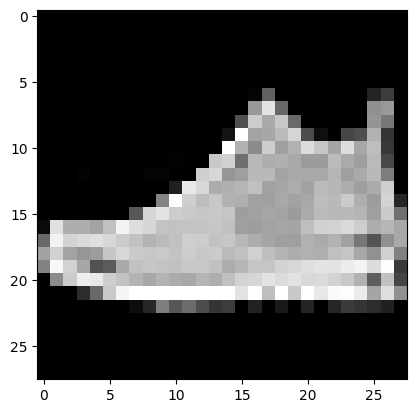

In [ ]:
plt.imshow(prueba.reshape(28,28), cmap="gray")

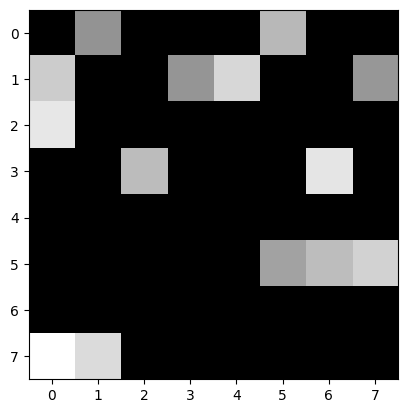

In [ ]:
plt.imshow(latent.reshape(8,8), cmap="gray")